In [1]:
import pandas as pd
import numpy as np
import math

from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score, make_uplift_scorer, uplift_by_percentile
from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# A: Artificial dataset of Control group
A_control = pd.read_csv("data/A_target.csv")

# Conversion group in A
A_cv = pd.read_csv("data/A_cv.csv")

# B: Artificial dataset of Treatment group
B_treat = pd.read_csv("data/B_target.csv")

# Conversion group in B
B_cv = pd.read_csv("data/B_cv.csv")


B_treat['treat'] = 1
treat_react_idx = B_treat[B_treat['customer_id'].isin(B_cv['customer_id'])]['customer_id'].index
B_treat['y'] = 0
B_treat.loc[treat_react_idx, 'y'] = 1

A_control['treat'] = 0
control_react_idx = A_control[A_control['customer_id'].isin(A_cv['customer_id'])]['customer_id'].index
A_control['y'] = 0
A_control.loc[control_react_idx, 'y'] = 1

print(A_control.treat.value_counts())
print(A_control.y.value_counts())
print()
print(B_treat.treat.value_counts())
print(B_treat.y.value_counts())

0    11129
Name: treat, dtype: int64
0    10948
1      181
Name: y, dtype: int64

1    11721
Name: treat, dtype: int64
0    11533
1      188
Name: y, dtype: int64


In [3]:
over_sampler = SMOTE(random_state=123, sampling_strategy=0.1)
x_resampled_control, y_resampled_control = over_sampler.fit_resample(A_control.drop(columns=['customer_id', 'y']), A_control['y'])
x_resampled_treat, y_resampled_treat = over_sampler.fit_resample(B_treat.drop(columns=['customer_id', 'y']), B_treat['y'])

print(x_resampled_control.treat.value_counts())
print(y_resampled_control.value_counts())
print(x_resampled_treat.treat.value_counts())
print(y_resampled_treat.value_counts())

0    12042
Name: treat, dtype: int64
0    10948
1     1094
Name: y, dtype: int64
1    12686
Name: treat, dtype: int64
0    11533
1     1153
Name: y, dtype: int64


In [4]:
X = pd.concat([x_resampled_control, x_resampled_treat], axis=0)
X.reset_index(drop=True, inplace=True)

y = pd.concat([y_resampled_control, y_resampled_treat], axis=0)
y.reset_index(drop=True, inplace=True)

df = pd.concat([X, y], axis=1)

In [5]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['y', 'treat'])), columns=df.columns.drop(['y', 'treat'])) 

y = df['y']
treat = df['treat']
X_scaled = X_scaled

x_train, x_test, y_train, y_test, treat_train, treat_test = train_test_split(X_scaled, y, treat, test_size=0.2, random_state=12)

In [6]:
ct = ClassTransformation(CatBoostClassifier(verbose=False, random_state=123))
ct.fit(x_train, y_train, treat_train)

ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7f2c605ee710>)

In [7]:
uplift_ct = ct.predict(x_test)

uplift_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)
print(f"Uplift at 30%: {uplift_score:.2f}")

Uplift at 30%: 0.23


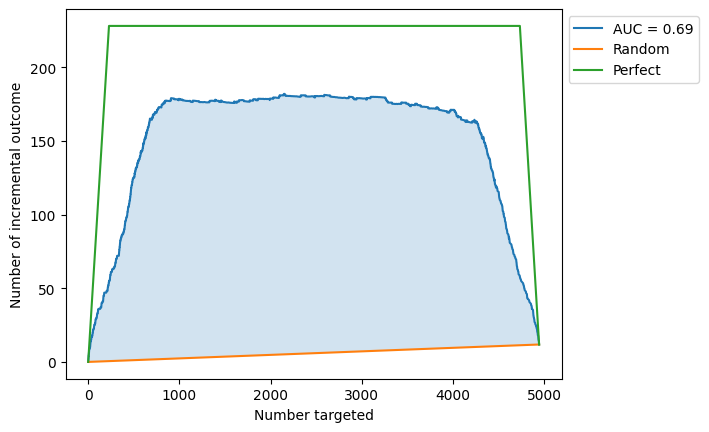

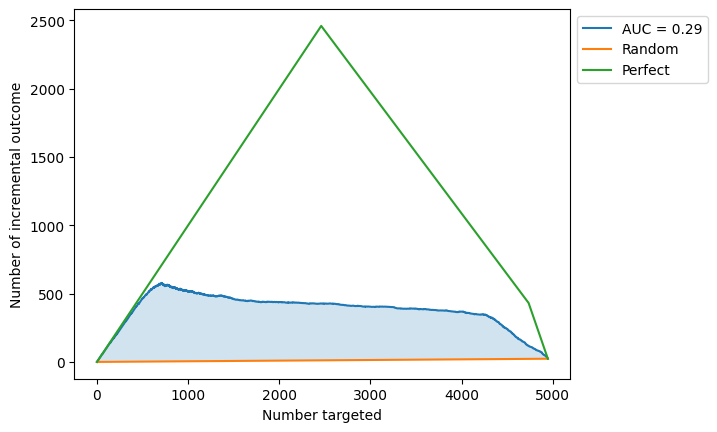

In [8]:
plot_qini_curve(y_true=y_test, uplift=uplift_ct, treatment=treat_test)
plot_uplift_curve(y_test, uplift_ct, treat_test)
plt.show()

In [9]:
ct2 = ClassTransformation(RandomForestClassifier(random_state=123))
ct2.fit(x_train, y_train, treat_train)
uplift_ct2 = ct2.predict(x_test)

ct3 = ClassTransformation(XGBClassifier(random_state=12))
ct3.fit(x_train, y_train, treat_train)
uplift_ct3 = ct3.predict(x_test)

In [10]:
print(uplift_at_k(y_test, uplift_ct, treat_test, strategy='by_group', k=0.3))
print(qini_auc_score(y_test, uplift_ct, treat_test))
print(uplift_auc_score(y_test, uplift_ct, treat_test))
print()

print(uplift_at_k(y_test, uplift_ct2, treat_test, strategy='by_group', k=0.3))
print(qini_auc_score(y_test, uplift_ct2, treat_test))
print(uplift_auc_score(y_test, uplift_ct2, treat_test))
print()

print(uplift_at_k(y_test, uplift_ct3, treat_test, strategy='by_group', k=0.3))
print(qini_auc_score(y_test, uplift_ct3, treat_test))
print(uplift_auc_score(y_test, uplift_ct3, treat_test))

0.2325792349726776
0.6860177781849437
0.28991160910814595

0.2689726775956284
0.8175520697354677
0.28323579075443733

0.2529398907103825
0.6889544125041063
0.28523654704831797


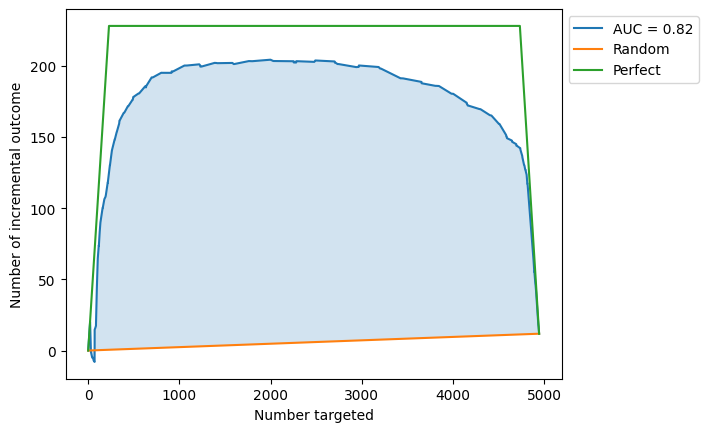

In [11]:
plot_qini_curve(y_test, uplift_ct2, treat_test)

In [12]:
estimator = RandomForestClassifier()
ct = ClassTransformation(estimator=estimator)
qini_scorer = make_uplift_scorer('qini_auc_score', treat_train)
uplift50_scorer = make_uplift_scorer("uplift_at_k", treat_train, strategy='overall', k=0.5)

params = {
    'estimator__n_estimators': [50, 100],
    #'estimator__max_depth': [None, 5, 10, 20, 30, 50, 100],
    #'estimator__max_features': ['sqrt', 'log2'],
    'estimator__min_samples_split': [2, 3, 5], 
    #'estimator__min_samples_leaf': [1, 2, 4], 
    #'estimator__bootstrap': [True, False],
    'estimator__random_state': [123] 
}

grid = GridSearchCV(ct, param_grid=params, scoring=qini_scorer)
grid = grid.fit(x_train, y_train, treatment=treat_train)

In [13]:
print(grid.best_estimator_)
print(grid.best_score_)

ClassTransformation(estimator=RandomForestClassifier(min_samples_split=3,
                                                     random_state=123))
0.7811423571380086


In [14]:
estimator = grid.best_estimator_.estimator
ct = ClassTransformation(estimator=estimator)
ct.fit(x_train, y_train, treat_train)
uplift_ct = ct.predict(x_test)

print(uplift_at_k(y_test, uplift_ct, treat_test, strategy='by_group', k=0.3))
print(qini_auc_score(y_test, uplift_ct, treat_test))
print(uplift_auc_score(y_test, uplift_ct, treat_test))

0.27167213114754096
0.8067526939695783
0.2801771008766478


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


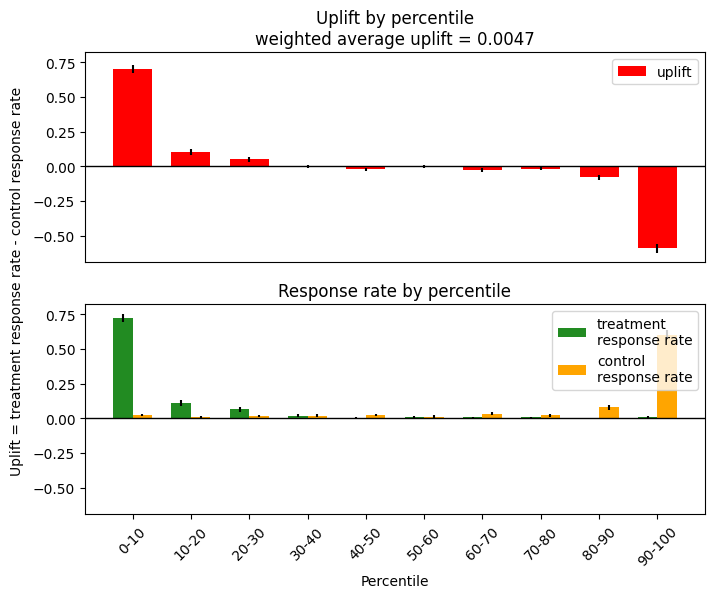

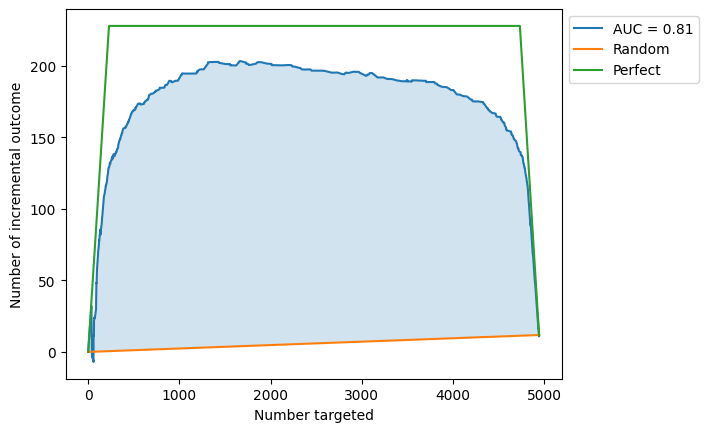

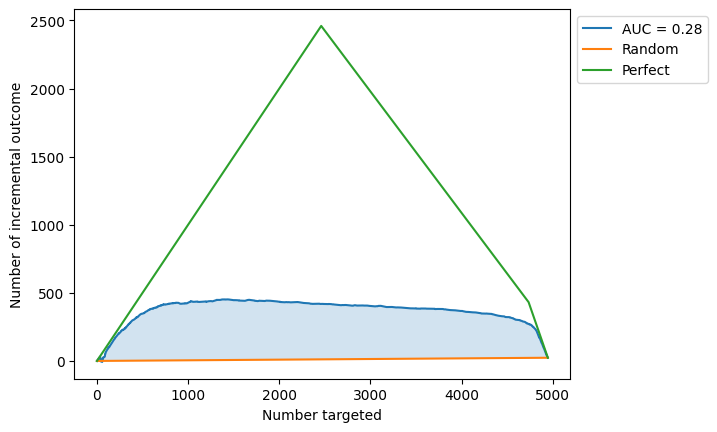

In [15]:
plot_uplift_by_percentile(y_test, uplift_ct, treat_test, kind='bar')
plot_qini_curve(y_test, uplift_ct, treat_test)
plot_uplift_curve(y_test, uplift_ct, treat_test)
plt.show()

100%|===================| 4942/4946 [02:16<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


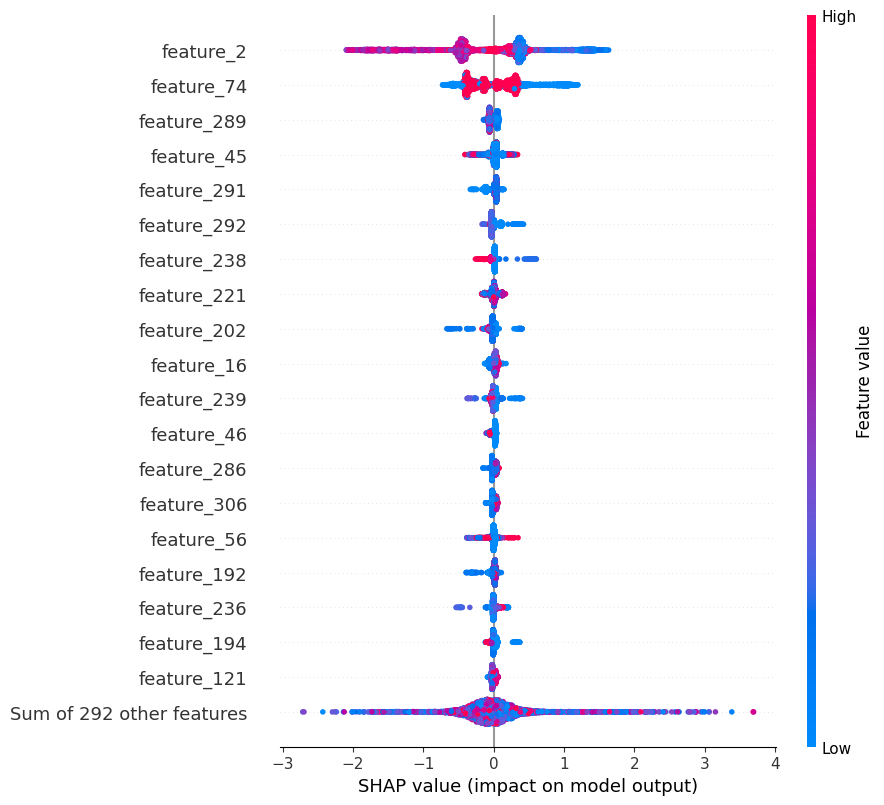

In [16]:
estimator = CatBoostClassifier(random_state=123, verbose=False)
ct = ClassTransformation(estimator=estimator)
ct.fit(x_train, y_train, treat_train)
uplift_ct = ct.predict(x_test)

explainer = shap.Explainer(ct.estimator, x_train)
shap_values = explainer(x_test)
shap.plots.beeswarm(shap_values, max_display=20)
plt.show()

In [17]:
estimator = RandomForestClassifier(random_state=123)
ct = ClassTransformation(estimator=estimator)
ct.fit(x_train, y_train, treat_train)
uplift_ct = ct.predict(x_test)

print(uplift_at_k(y_test, uplift_ct, treat_test, strategy='by_group', k=0.3))
print(qini_auc_score(y_test, uplift_ct, treat_test))
print(uplift_auc_score(y_test, uplift_ct, treat_test))

0.2689726775956284
0.8175520697354677
0.28323579075443733


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


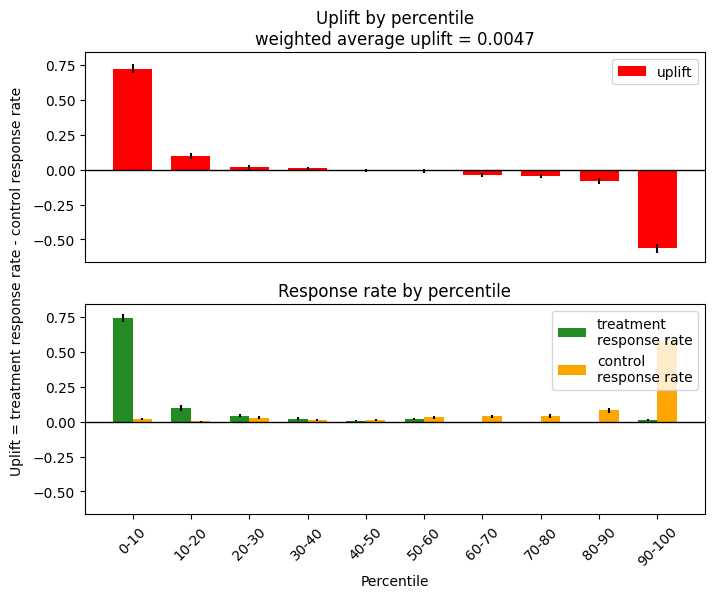

In [18]:
plot_uplift_by_percentile(y_test, uplift_ct, treat_test, kind='bar')
plt.show()

In [19]:
# Persuadables: High Positive
# Sure Things: Low Positive or Near Zero
# Do-Not-Disturbs: High Negative
# Lost Causes: Low Negative

In [20]:
def calculate_segments(original_data, y, uplift, treatment):
    segments = {'persuadables': 0, 'sure_things': 0, "dnd": 0, "lost_causes": 0}
    
    for dec_uplift in uplift_by_percentile(y, uplift, treatment, strategy='overall', bins=50)['uplift']:
        if dec_uplift >= 0.1:
            segments['persuadables'] += 2
        elif dec_uplift < 0.1 and dec_uplift >= 0:
            segments['sure_things'] += 2
        elif dec_uplift < 0 and dec_uplift > -0.1:
            segments['lost_causes'] += 2
        else:
            segments['dnd'] += 2
    
    for key in [*segments.keys()]:
        segments[key] = math.floor(len(original_data) * segments[key] / 100)
    
    return segments

In [21]:
calculate_segments(df, y_test, uplift_ct, treat_test)

{'persuadables': 3461, 'sure_things': 7912, 'dnd': 3956, 'lost_causes': 9396}

In [22]:
sum([*calculate_segments(df, y_test, uplift_ct, treat_test).values()])

24725